# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

목표 : 네이버 영화의 댓글 데이터셋을 활용하여 한국어 텍스트 감정분석을 한다. 

## 1) 데이터 준비와 확인

In [3]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

### 2-1) load_data 함수

In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    # 중복제거와 NaN 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    # 컬럼 document의 문장들을 토큰화,불용어제거하여 X_train리스트에 저장
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    # 컬럼 document의 문장들을 토큰화,불용어제거하여 X_test리스트에 저장
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 사전word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4) #가장 숫자가 많은 9996개 데이터
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
       
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

### 2-2) index:word 로 구성된 딕셔너리 생성

In [5]:
# index 와 단어 딕셔너리 구성
index_to_word = {index:word for word, index in word_to_index.items()}

### 2-3) 문장과 인덱스간 인코드 디코드 함수들 생성

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포  
- 적절한 최대 문장 길이 지정  
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가  


pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일하는 것을 잊어선 안됨.  
문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 된다.  
이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋다.  

In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


#### 패딩 추가 
최대 길이를 41로 세팅

In [8]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen) #41

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen) #41

print(X_train.shape)

(146182, 41)


## 4) 모델구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험

### 4-1) CNN

In [36]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 50  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))  
cnn_model.add(keras.layers.MaxPooling1D(5))
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(keras.layers.GlobalMaxPooling1D())
cnn_model.add(keras.layers.Dense(8, activation='relu'))
cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
cnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 50)          500000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 16)          5616      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

### 4-2) RNN

In [37]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 50  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
rnn_model = keras.Sequential()

rnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
rnn_model.add(keras.layers.Dense(16, activation='relu'))
rnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 50)          500000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_22 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 530,497
Trainable params: 530,497
Non-trainable params: 0
_________________________________________________________________


### 4-3) GlobalMaxPooling1D 하나만 사용한 모델

In [38]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 50  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

maxpool1_model = keras.Sequential()
maxpool1_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
maxpool1_model.add(keras.layers.GlobalMaxPooling1D())
maxpool1_model.add(keras.layers.Dense(8, activation='relu'))
maxpool1_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

maxpool1_model.summary()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 50)          500000    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 408       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 500,417
Trainable params: 500,417
Non-trainable params: 0
_________________________________________________________________


### Validation Set 분리

In [39]:
# validation set 분리
val_set_size = int(len(X_train) * 0.2)

x_val = X_train[:val_set_size]
y_val = y_train[:val_set_size]

partial_x_train = X_train[val_set_size:]
partial_y_train = y_train[val_set_size:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116946, 41)
(116946,)


## 5) 모델 훈련 개시

In [40]:
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

cnn_history = cnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/3
229/229 [==============================] - 2s 8ms/step - loss: 0.4798 - accuracy: 0.7639 - val_loss: 0.3495 - val_accuracy: 0.8470
Epoch 2/3
229/229 [==============================] - 2s 8ms/step - loss: 0.3199 - accuracy: 0.8643 - val_loss: 0.3346 - val_accuracy: 0.8551
Epoch 3/3
229/229 [==============================] - 2s 7ms/step - loss: 0.2806 - accuracy: 0.8850 - val_loss: 0.3344 - val_accuracy: 0.8567


In [41]:
rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

rnn_history = rnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
229/229 [==============================] - 2s 10ms/step - loss: 0.4387 - accuracy: 0.7969 - val_loss: 0.3487 - val_accuracy: 0.8501
Epoch 2/5
229/229 [==============================] - 2s 9ms/step - loss: 0.3308 - accuracy: 0.8583 - val_loss: 0.3395 - val_accuracy: 0.8529
Epoch 3/5
229/229 [==============================] - 2s 9ms/step - loss: 0.3046 - accuracy: 0.8720 - val_loss: 0.3369 - val_accuracy: 0.8529
Epoch 4/5
229/229 [==============================] - 2s 9ms/step - loss: 0.2832 - accuracy: 0.8811 - val_loss: 0.3403 - val_accuracy: 0.8524
Epoch 5/5
229/229 [==============================] - 2s 9ms/step - loss: 0.2604 - accuracy: 0.8908 - val_loss: 0.3514 - val_accuracy: 0.8551


In [42]:
maxpool1_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

maxpool1_history = maxpool1_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
229/229 [==============================] - 2s 7ms/step - loss: 0.5562 - accuracy: 0.7781 - val_loss: 0.3825 - val_accuracy: 0.8325
Epoch 2/5
229/229 [==============================] - 2s 7ms/step - loss: 0.3458 - accuracy: 0.8519 - val_loss: 0.3444 - val_accuracy: 0.8480
Epoch 3/5
229/229 [==============================] - 2s 7ms/step - loss: 0.2990 - accuracy: 0.8755 - val_loss: 0.3404 - val_accuracy: 0.8513
Epoch 4/5
229/229 [==============================] - 2s 7ms/step - loss: 0.2675 - accuracy: 0.8914 - val_loss: 0.3457 - val_accuracy: 0.8526
Epoch 5/5
229/229 [==============================] - 2s 7ms/step - loss: 0.2413 - accuracy: 0.9036 - val_loss: 0.3560 - val_accuracy: 0.8525


## 6) Loss, Accuracy 그래프 시각화

### 6-1) cnn loss 34.4%, accuracy 85.2%

In [43]:
cnn_results = cnn_model.evaluate(X_test,  y_test, verbose=2)

print(cnn_results)

1537/1537 - 2s - loss: 0.3442 - accuracy: 0.8529
[0.34423795342445374, 0.8529202342033386]


### 6-2) rnn loss 35.9%, accuracy 85.1%

In [44]:
rnn_results = rnn_model.evaluate(X_test,  y_test, verbose=2)

print(rnn_results)

1537/1537 - 2s - loss: 0.3599 - accuracy: 0.8511
[0.35990577936172485, 0.8510690331459045]


### 6-3) GlobalMaxPooling1D 사용 모델 loss 36.6%, accuracy 84.7%

In [45]:
maxpool1_results = maxpool1_model.evaluate(X_test,  y_test, verbose=2)

print(maxpool1_results)

1537/1537 - 1s - loss: 0.3668 - accuracy: 0.8470
[0.36682185530662537, 0.847041130065918]


In [46]:
cnn_history_dict = cnn_history.history
rnn_history_dict = rnn_history.history
maxpool1_history_dict = maxpool1_history.history

### 6-4) cnn loss 그래프

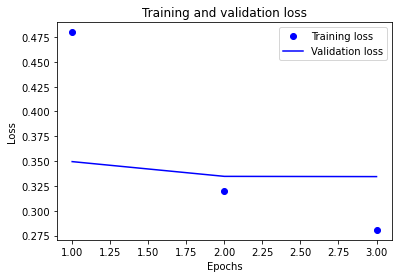

In [110]:
import matplotlib.pyplot as plt

acc = cnn_history_dict['accuracy']
val_acc = cnn_history_dict['val_accuracy']
loss = cnn_history_dict['loss']
val_loss = cnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 6-5) rnn loss 그래프

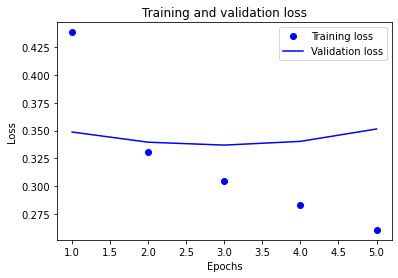

In [112]:
import matplotlib.pyplot as plt

acc = rnn_history_dict['accuracy']
val_acc = rnn_history_dict['val_accuracy']
loss = rnn_history_dict['loss']
val_loss = rnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 6-5) GlobalMaxPooling1D 사용 모델 loss 그래프

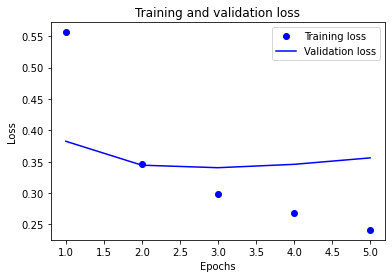

In [113]:
import matplotlib.pyplot as plt

acc = maxpool1_history_dict['accuracy']
val_acc = maxpool1_history_dict['val_accuracy']
loss = maxpool1_history_dict['loss']
val_loss = maxpool1_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

모델의 epochs를 validation loss가 최저점일 때를 기준으로 parameter를 설정했다. 

## 7) 학습된 Embedding 레이어 분석

가장 일반적인 RNN의 LSTM모델을 가지고 레이어 분석을 해 보았다.

In [48]:
embedding_layer = cnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 50)


In [50]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = cnn_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [51]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['좋아']
vector

array([ 0.03873442,  0.0577103 , -0.11401554, -0.0071678 ,  0.01170083,
        0.01700411, -0.01545547, -0.01336762, -0.02546445,  0.02623906,
        0.00043322, -0.0513473 ,  0.0939004 ,  0.06694151, -0.07537305,
       -0.07772529,  0.0112626 ,  0.03175155,  0.02131327,  0.03882179,
       -0.03804678, -0.01997249, -0.01691374,  0.03218263, -0.05494663,
       -0.05419112,  0.05170074, -0.00386254,  0.03015829,  0.01242076,
       -0.02174939, -0.00409712,  0.01001945,  0.03737899,  0.04283369,
       -0.00125372,  0.03088208, -0.0159958 ,  0.02527095, -0.06600178,
        0.03188527, -0.03988124, -0.01250375,  0.00569736,  0.00579362,
        0.00122488, -0.02971818, -0.03204181,  0.01367155, -0.00892579],
      dtype=float32)

In [52]:
# 좋아 단어로 비슷한 단어 도출해보기 
word_vectors.similar_by_word("좋아")

[('11', 0.5844257473945618),
 ('영화채널', 0.5522648692131042),
 ('떄', 0.5488848090171814),
 ('젼', 0.5425660014152527),
 ('쾌감', 0.5423775911331177),
 ('채웠', 0.5284819602966309),
 ('시트콤', 0.5263713598251343),
 ('케이지', 0.5167561173439026),
 ('부여', 0.5046709179878235),
 ('이야', 0.5016384124755859)]

학습된 임베딩 레이어로 분석해보니 다소 의미가 동 떨어진 단어들이 도출되었다.

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [53]:
#Google의 Word2Vec 모델을 가져와 적용
#$ mv ~/Downloads/GoogleNews-vectors-negative300.bin.gz ~/aiffel/sentiment_classification

from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)

In [54]:
# love 단어로 비슷한 느낌의 단어 도출해보기
word2vec.similar_by_word("love")

[('loved', 0.6907792687416077),
 ('adore', 0.6816874742507935),
 ('loves', 0.6618634462356567),
 ('passion', 0.6100707650184631),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [95]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [107]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 41, 300)           3000000   
_________________________________________________________________
lstm_13 (LSTM)               (None, 16)                20288     
_________________________________________________________________
dense_54 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 17        
Total params: 3,020,577
Trainable params: 3,020,577
Non-trainable params: 0
_________________________________________________________________


In [108]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
229/229 [==============================] - 8s 35ms/step - loss: 0.4813 - accuracy: 0.7600 - val_loss: 0.3998 - val_accuracy: 0.8210
Epoch 2/5
229/229 [==============================] - 8s 34ms/step - loss: 0.3407 - accuracy: 0.8534 - val_loss: 0.3459 - val_accuracy: 0.8480
Epoch 3/5
229/229 [==============================] - 8s 34ms/step - loss: 0.3056 - accuracy: 0.8717 - val_loss: 0.3427 - val_accuracy: 0.8485
Epoch 4/5
229/229 [==============================] - 8s 34ms/step - loss: 0.2850 - accuracy: 0.8808 - val_loss: 0.3394 - val_accuracy: 0.8527
Epoch 5/5
229/229 [==============================] - 8s 34ms/step - loss: 0.2661 - accuracy: 0.8903 - val_loss: 0.3395 - val_accuracy: 0.8570


In [109]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3504 - accuracy: 0.8502
[0.3504347801208496, 0.8502146005630493]


# 느낀점

성능개선에 Word2Vec 임베딩을 활용하였지만, 최종85%로 생각만큼 성능이 개선 되질 않았다.   
딥러닝을 더 공부하여 하이퍼파라미터 각각의 의미를 좀 더 파악하면 좋겠다는 생각을 하였다.  

감성분석에도 이미지분석에 쓰이는 CNN이 쓰일 수 있다는 것을 알았고,  
정확한 분석을 위해서 역시 잘 정제된 데이터가 많이 필요하다는 것을 깨닫는 시간이였다.  